<a href="https://colab.research.google.com/github/JaminUbuntu/IBOK_OPT/blob/main/Optimization_IBOKb_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package Installation and Library Importations

Run the first code block twice (Restart) to properly initiate GPy

In [1]:
# Install the combination of compatible versions for colab
!pip install numpy==1.24.2
!pip install scipy==1.10.0
!pip install GPy
!pip install GPyOpt

  Using cached scipy-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached scipy-1.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.1 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.2 which is incompatible.
cvxpy 1.6.4 requires scipy>=1.11.0, but you have scipy 1.10.0 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.2 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.0 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.2 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1

In [74]:
import os
import GPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import learning_curve
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_absolute_error, mean_squared_error
from math import sqrt

# Loading the Data

In [4]:
file = '/content/Folds5x2_pp.xlsx'

df = pd.read_excel(file)
df

AT      V       AP     RH      PE
0     14.96  41.76  1024.07  73.17  463.26
1     25.18  62.96  1020.04  59.08  444.37
2      5.11  39.40  1012.16  92.14  488.56
3     20.86  57.32  1010.24  76.64  446.48
4     10.82  37.50  1009.23  96.62  473.90
...     ...    ...      ...    ...     ...
9563  16.65  49.69  1014.01  91.00  460.03
9564  13.19  39.18  1023.67  66.78  469.62
9565  31.32  74.33  1012.92  36.48  429.57
9566  24.48  69.45  1013.86  62.39  435.74
9567  21.60  62.52  1017.23  67.87  453.28

[9568 rows x 5 columns]

# Data Preprocessing / EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


In [6]:
df.describe().style.background_gradient(cmap='Blues')

In [7]:
df.shape

(9568, 5)

In [8]:
df.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [9]:
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [10]:
df.duplicated().sum()

41

In [11]:
duplicates = df[df.duplicated(keep=False)]

print(duplicates)

         AT      V       AP     RH      PE
231   26.85  75.60  1017.43  74.55  433.48
345   12.19  41.17  1019.43  65.47  475.64
352   25.56  75.60  1017.37  69.31  442.20
468   25.21  75.60  1017.19  69.84  445.84
726   28.41  75.60  1018.48  56.07  440.28
...     ...    ...      ...    ...     ...
9147   7.64  41.17  1020.01  75.14  488.53
9201  29.51  75.60  1017.92  50.61  431.18
9345   8.57  41.17  1020.18  72.47  484.20
9350  12.27  41.17  1019.41  58.10  475.13
9523  12.27  41.17  1019.41  58.10  475.13

[82 rows x 5 columns]


The duplicates are possibly coincidences...

In [12]:
duplicates = df[df.duplicated(keep=False)].value_counts()

print(duplicates)

AT     V      AP       RH     PE    
6.03   41.17  1019.81  84.20  488.57    2
24.63  59.57  1010.45  85.36  440.67    2
25.21  75.60  1017.19  69.84  445.84    2
25.42  75.60  1017.39  77.63  438.24    2
25.53  59.57  1010.65  82.04  445.59    2
25.56  75.60  1017.37  69.31  442.20    2
25.79  75.60  1017.46  75.63  434.65    2
25.91  75.60  1018.23  62.65  443.20    2
26.12  75.60  1017.41  72.31  439.68    2
26.45  75.60  1017.42  74.50  436.89    2
26.85  75.60  1017.43  74.55  433.48    2
27.54  75.60  1018.26  57.89  440.87    2
27.64  75.60  1017.35  54.78  441.04    2
28.37  75.60  1017.48  55.19  439.25    2
28.41  75.60  1018.48  56.07  440.28    2
28.84  75.60  1018.41  53.96  442.69    2
29.05  75.60  1017.63  51.16  439.14    2
29.23  75.60  1017.72  52.26  438.92    2
29.45  75.60  1018.12  50.68  437.31    2
24.79  75.60  1017.07  68.23  440.05    2
12.27  41.17  1019.41  58.10  475.13    2
6.06   41.17  1019.67  84.70  489.62    2
12.27  41.17  1019.39  52.18  473.84   

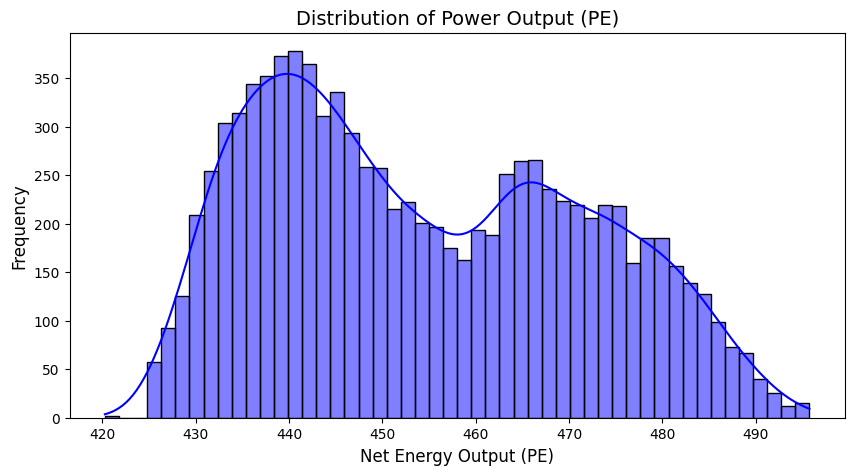

In [13]:
# Plotting the distribution of the target variable (PE)
plt.figure(figsize=(10, 5))
sns.histplot(df['PE'], bins=50, kde=True, color="blue", edgecolor="black")

# Titles and labels
plt.title("Distribution of Power Output (PE)", fontsize=14)
plt.xlabel("Net Energy Output (PE)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Show plot
plt.show()

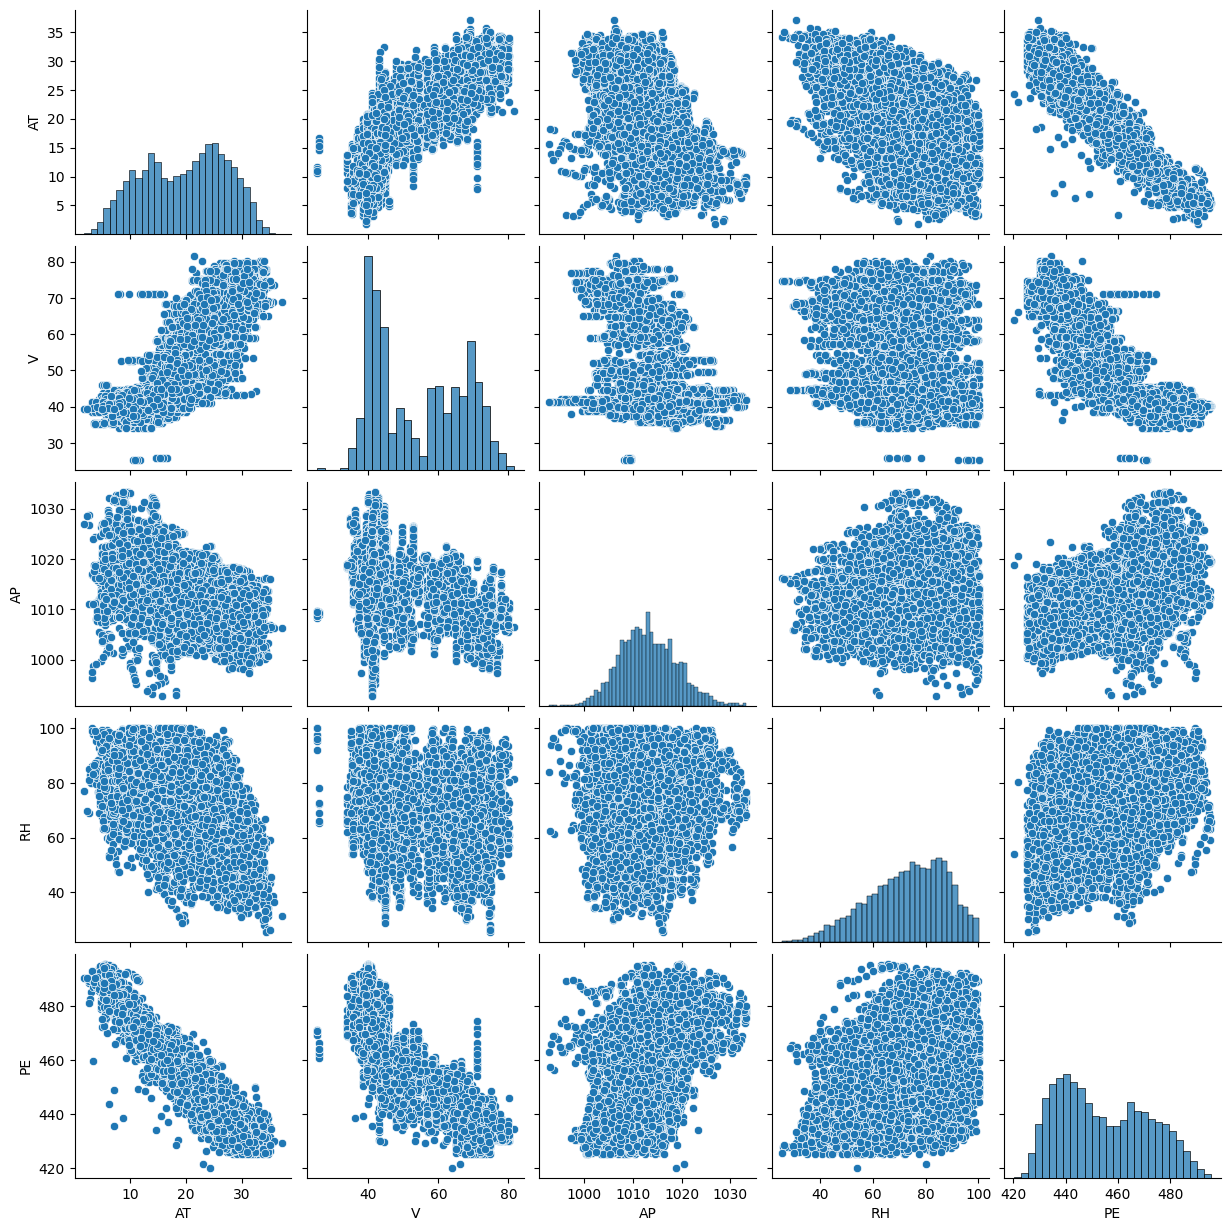

In [14]:
df_compare = sns.pairplot(df)

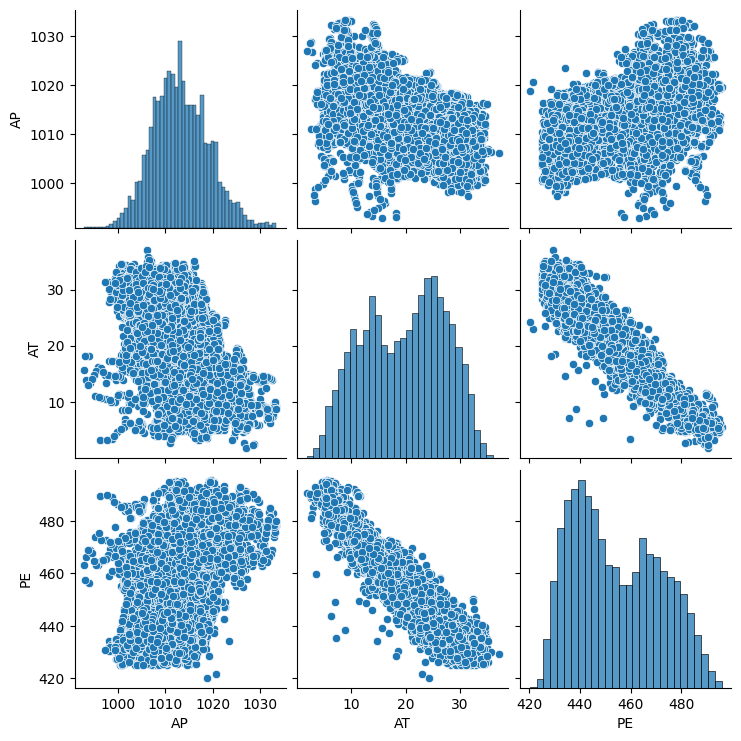

In [15]:
df_compare = sns.pairplot(df[['AP', 'AT', 'PE']])

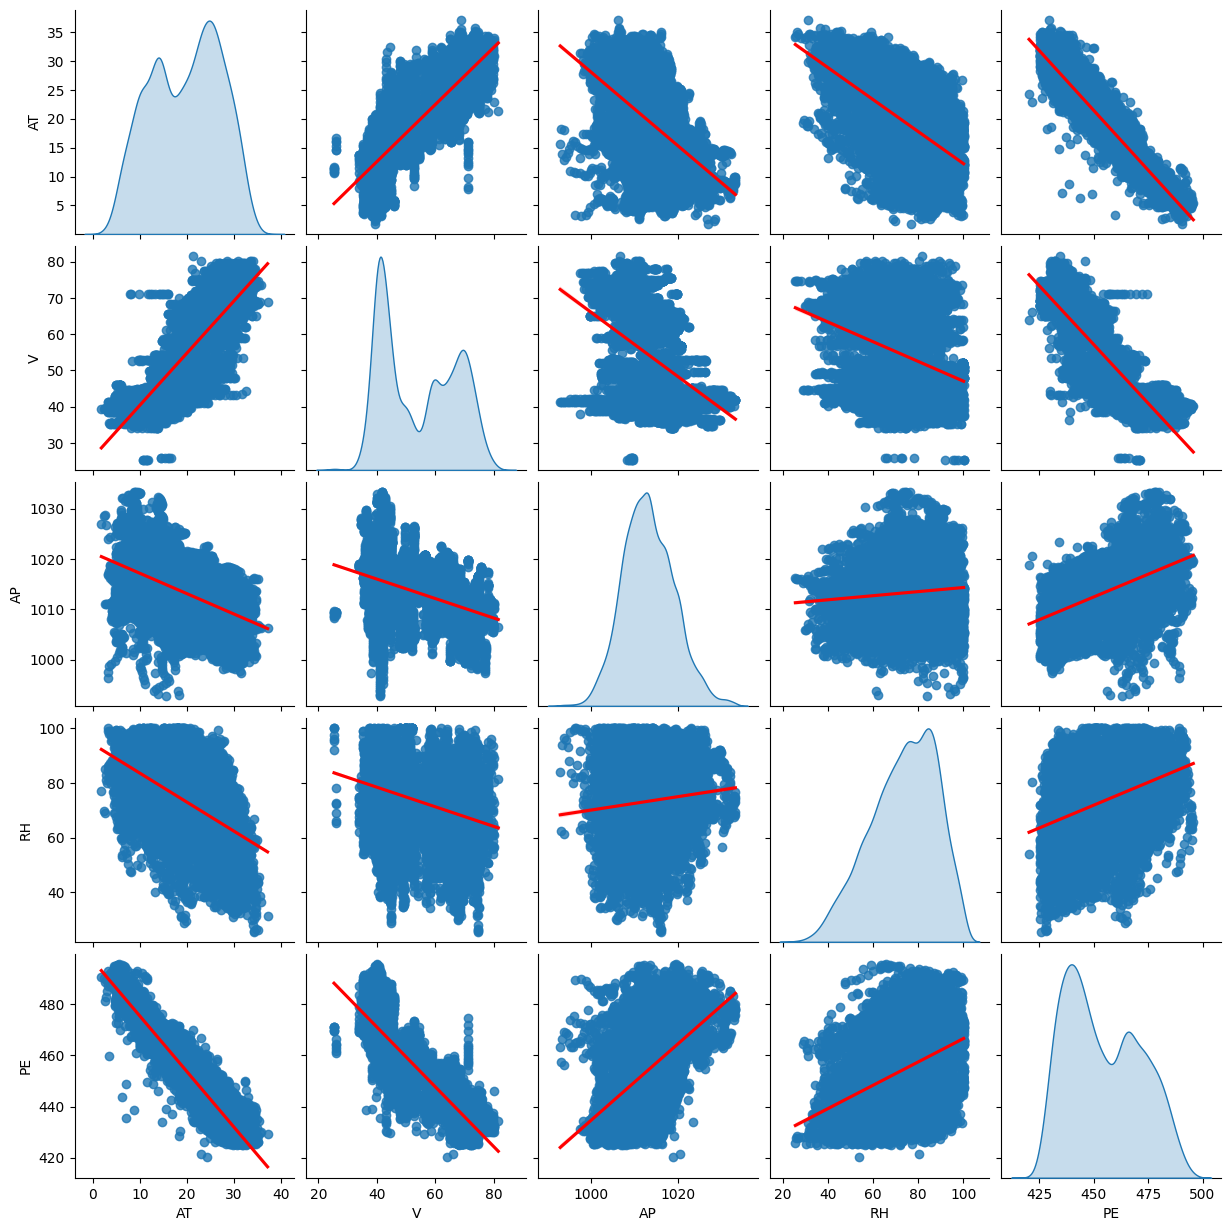

In [16]:
viz2 = sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}}, diag_kind='kde')

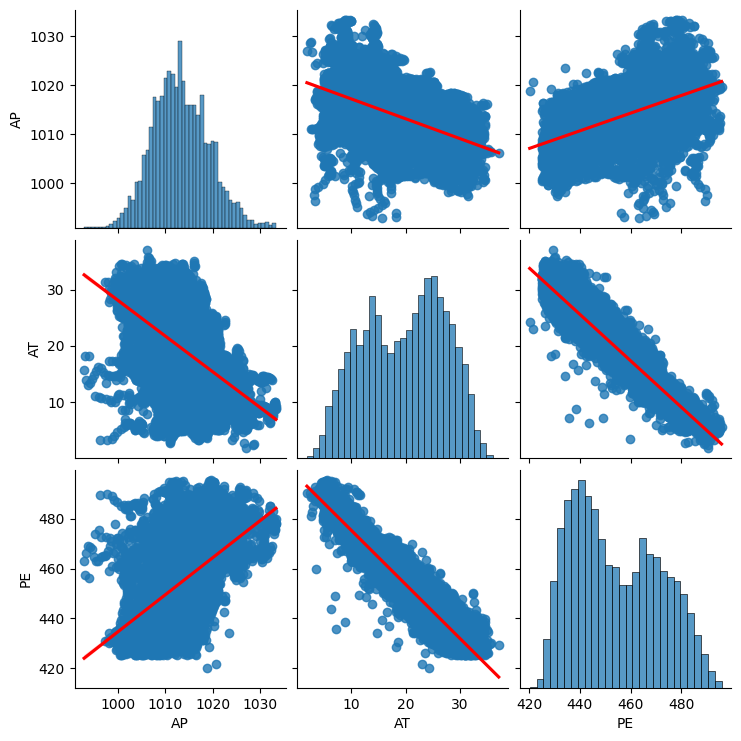

In [17]:
df_compare = sns.pairplot(df[['AP', 'AT', 'PE']], kind='reg', plot_kws={'line_kws':{'color':'red'}})

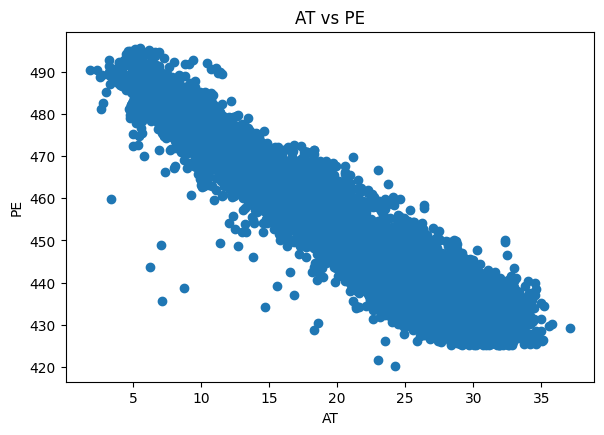

In [18]:
plt.figure(figsize=(15,10))
plt.tight_layout()
plt.subplot(2,2,1)
plt.plot(df['AT'], df['PE'], 'o')
plt.title('AT vs PE')
plt.xlabel('AT')
plt.ylabel('PE')
plt.show()

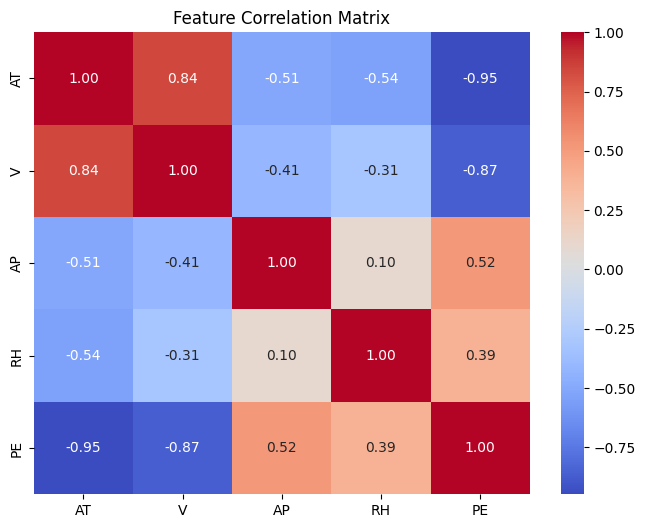

In [19]:
# Compute correlation matrix
corr_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

# Target Selection

In [20]:
X = df.drop('PE', axis =  1)
y = df['PE']

In [21]:
X

AT      V       AP     RH
0     14.96  41.76  1024.07  73.17
1     25.18  62.96  1020.04  59.08
2      5.11  39.40  1012.16  92.14
3     20.86  57.32  1010.24  76.64
4     10.82  37.50  1009.23  96.62
...     ...    ...      ...    ...
9563  16.65  49.69  1014.01  91.00
9564  13.19  39.18  1023.67  66.78
9565  31.32  74.33  1012.92  36.48
9566  24.48  69.45  1013.86  62.39
9567  21.60  62.52  1017.23  67.87

[9568 rows x 4 columns]

In [22]:
y

0       463.26
1       444.37
2       488.56
3       446.48
4       473.90
         ...  
9563    460.03
9564    469.62
9565    429.57
9566    435.74
9567    453.28
Name: PE, Length: 9568, dtype: float64

In [23]:
print(X.shape)
print(y.shape)

(9568, 4)
(9568,)


# Feature Scaling using Robust Scaler

In [24]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X.to_numpy())

X_scaled2 = pd.DataFrame(X_scaled, columns=[X.columns])
X_scaled2.head()

AT         V        AP        RH
0 -0.441032 -0.416129  1.363971 -0.083944
1  0.395987  0.438710  0.870098 -0.739216
2 -1.247748 -0.511290 -0.095588  0.798279
3  0.042179  0.211290 -0.330882  0.077433
4 -0.780098 -0.587903 -0.454657  1.006627

In [25]:
X_scaled

array([[-0.44103194, -0.41612903,  1.36397059, -0.08394373],
       [ 0.3959869 ,  0.43870968,  0.87009804, -0.73921637],
       [-1.24774775, -0.51129032, -0.09558824,  0.79827927],
       ...,
       [ 0.8988534 ,  0.89717742, -0.00245098, -1.79025695],
       [ 0.33865684,  0.70040323,  0.1127451 , -0.58528078],
       [ 0.1027846 ,  0.42096774,  0.52573529, -0.33042669]])

In [26]:
# Scale y since we will be using GPR

scaler = RobustScaler()
y_scaled = scaler.fit_transform(y.to_numpy().reshape(-1, 1))

y_scaled2 = pd.DataFrame(y_scaled, columns=['PE'])
y_scaled2.head()

PE
0  0.408298
1 -0.250349
2  1.290446
3 -0.176778
4  0.779289

In [27]:
y_scaled

array([[ 0.40829847],
       [-0.25034868],
       [ 1.2904463 ],
       ...,
       [-0.76638773],
       [-0.55125523],
       [ 0.06032078]])

# Applying The Gaussian Mixture Model

In [28]:
# Apply Gaussian Mixture Model (GMM) with 2 clusters
gmm = GaussianMixture(n_components=2, random_state=42)
df['Cluster'] = gmm.fit_predict(y_scaled)  # Assign cluster labels

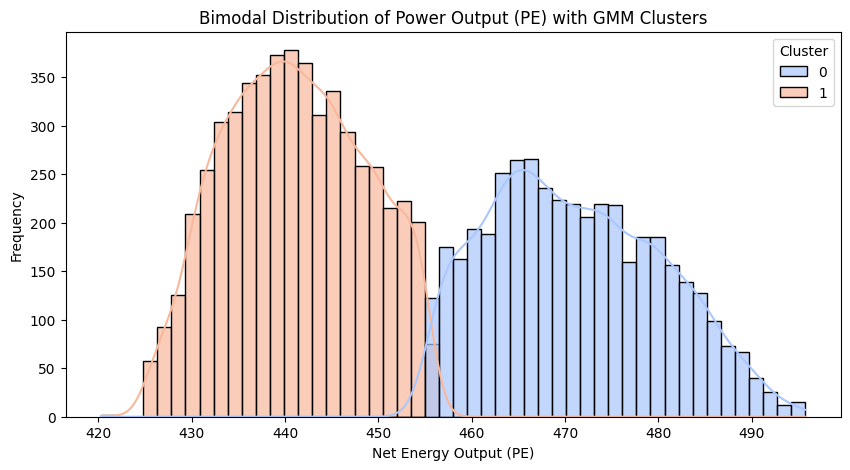

In [29]:
# Visualize the clusters in the PE distribution
plt.figure(figsize=(10, 5))
sns.histplot(df, x="PE", hue="Cluster", kde=True, bins=50, palette="coolwarm", alpha=0.7)
plt.title("Bimodal Distribution of Power Output (PE) with GMM Clusters")
plt.xlabel("Net Energy Output (PE)")
plt.ylabel("Frequency")
plt.show()

In [30]:
# Print cluster Means to interpret separation
print("Cluster Means (Centers):", gmm.means_.flatten())

Cluster Means (Centers): [ 0.66368672 -0.35611201]


Seperating the Clusters

In [31]:
# Separating the clusters
df_cluster_0 = df[df['Cluster'] == 0]
df_cluster_1 = df[df['Cluster'] == 1]

In [32]:
df_cluster_0

AT      V       AP     RH      PE  Cluster
0     14.96  41.76  1024.07  73.17  463.26        0
2      5.11  39.40  1012.16  92.14  488.56        0
4     10.82  37.50  1009.23  96.62  473.90        0
6     15.89  43.96  1014.02  75.24  467.35        0
7      9.48  44.71  1019.12  66.43  478.42        0
...     ...    ...      ...    ...     ...      ...
9552   7.17  39.40  1011.48  90.38  484.33        0
9561  11.76  41.58  1020.91  88.35  465.45        0
9562  14.02  40.10  1015.56  82.44  467.32        0
9563  16.65  49.69  1014.01  91.00  460.03        0
9564  13.19  39.18  1023.67  66.78  469.62        0

[4229 rows x 6 columns]

In [33]:
df_cluster_1

AT      V       AP     RH      PE  Cluster
1     25.18  62.96  1020.04  59.08  444.37        1
3     20.86  57.32  1010.24  76.64  446.48        1
5     26.27  59.44  1012.23  58.77  443.67        1
10    17.99  43.72  1008.64  75.04  453.02        1
11    20.14  46.93  1014.66  64.22  453.99        1
...     ...    ...      ...    ...     ...      ...
9559  26.22  49.82  1015.48  55.80  454.20        1
9560  23.27  68.28  1005.01  74.83  444.86        1
9565  31.32  74.33  1012.92  36.48  429.57        1
9566  24.48  69.45  1013.86  62.39  435.74        1
9567  21.60  62.52  1017.23  67.87  453.28        1

[5339 rows x 6 columns]

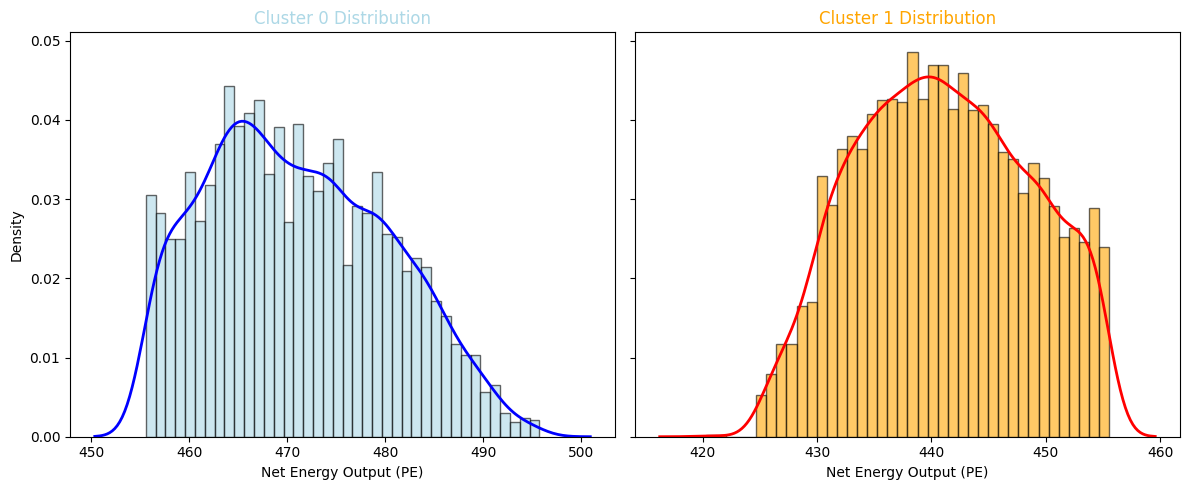

In [34]:
# Visualize the clusters in the PE distribution
cluster_0_pd = pd.DataFrame(df_cluster_0, columns=['PE'])
cluster_1_pd = pd.DataFrame(df_cluster_1, columns=['PE'])


# Define colors
color_0 = "lightblue"
color_1 = "orange"

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot Cluster 0 Histogram (Blue) with KDE
axes[0].hist(cluster_0_pd["PE"], bins=40, color=color_0, edgecolor='black', alpha=0.6, density=True)
sns.kdeplot(cluster_0_pd["PE"], color='blue', ax=axes[0], linewidth=2)
axes[0].set_title("Cluster 0 Distribution", color=color_0)
axes[0].set_xlabel("Net Energy Output (PE)")
axes[0].set_ylabel("Density")

# Plot Cluster 1 Histogram (Orange) with KDE
axes[1].hist(cluster_1_pd["PE"], bins=40, color=color_1, edgecolor='black', alpha=0.6, density=True)
sns.kdeplot(cluster_1_pd["PE"], color='red', ax=axes[1], linewidth=2)
axes[1].set_title("Cluster 1 Distribution", color=color_1)
axes[1].set_xlabel("Net Energy Output (PE)")
axes[1].set_ylabel("Density")

# Adjust layout and show
plt.tight_layout()
plt.show()

# Redefine Target and Predictor Variables

In [35]:
# Define features (X) and target (y)
features = [col for col in df.columns if col not in ['PE', 'Cluster']]

X0, y0 = df_cluster_0[features], df_cluster_0['PE']
X1, y1 = df_cluster_1[features], df_cluster_1['PE']

Perform numerical scaling using Robust Scaler

In [36]:
# Initialize RobustScaler
scaler_X = RobustScaler()
scaler_y = RobustScaler()

# Scale features and target for Cluster 0
X0_scaled = scaler_X.fit_transform(X0)
y0_scaled = scaler_y.fit_transform(y0.values.reshape(-1, 1)).flatten()

# Scale features and target for Cluster 1
X1_scaled = scaler_X.fit_transform(X1)
y1_scaled = scaler_y.fit_transform(y1.values.reshape(-1, 1)).flatten()

Train/Test Split

In [37]:
# Split into training and testing sets
X0_train, X0_test, y0_train, y0_test = train_test_split(X0_scaled, y0_scaled, test_size=0.2, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1_scaled, test_size=0.2, random_state=42)

Defining the Kernels for GPR

In [38]:
# Define kernels for GPR using GPy
kernels = {
    "RBF": GPy.kern.RBF(input_dim=X0_train.shape[1]),
    "Matern": GPy.kern.Matern32(input_dim=X0_train.shape[1]),
    "Linear": GPy.kern.Linear(input_dim=X0_train.shape[1])

}


Using a function to Train the Models

In [39]:
# Function to train GPy GPR models
def train_gpr(X_train, y_train, kernel):
    model = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), kernel)
    model.optimize()
    return model

# Train the Models

In [40]:
# Train GPR models for each cluster
gpr_models_0 = {name: train_gpr(X0_train, y0_train, kernel) for name, kernel in kernels.items()}
gpr_models_1 = {name: train_gpr(X1_train, y1_train, kernel) for name, kernel in kernels.items()}

# Train Linear Regression & Ridge Regression
lin_reg_0 = LinearRegression().fit(X0_train, y0_train)
lin_reg_1 = LinearRegression().fit(X1_train, y1_train)

ridge_reg_0 = Ridge(alpha=1.0).fit(X0_train, y0_train)
ridge_reg_1 = Ridge(alpha=1.0).fit(X1_train, y1_train)


Making Predictions

In [41]:
# Make predictions
predictions_scaled = {
    "Linear Regression (Cluster 0)": lin_reg_0.predict(X0_test),
    "Linear Regression (Cluster 1)": lin_reg_1.predict(X1_test),
    "Ridge Regression (Cluster 0)": ridge_reg_0.predict(X0_test),
    "Ridge Regression (Cluster 1)": ridge_reg_1.predict(X1_test),
}

for name, model in gpr_models_0.items():
    predictions_scaled[f"GPR-{name} (Cluster 0)"], _ = model.predict(X0_test)

for name, model in gpr_models_1.items():
    predictions_scaled[f"GPR-{name} (Cluster 1)"], _ = model.predict(X1_test)

Reverse Scaling

In [42]:
# Reverse scaling (inverse transform) to get actual values
predictions = {model_name: scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten() for model_name, y_pred in predictions_scaled.items()}

y0_test_actual = scaler_y.inverse_transform(y0_test.reshape(-1, 1)).flatten()
y1_test_actual = scaler_y.inverse_transform(y1_test.reshape(-1, 1)).flatten()


# Initianl Evaluation

In [43]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Evaluation for {model_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print("-" * 40)

In [44]:
# Evaluate all models
for model_name, y_pred_actual in predictions.items():
    y_true_actual = y0_test_actual if "Cluster 0" in model_name else y1_test_actual
    evaluate_model(y_true_actual, y_pred_actual, model_name)

Evaluation for Linear Regression (Cluster 0):
  - MAE: 2.7801
  - MSE: 12.3192
  - RMSE: 3.5099
  - R² Score: 0.7737
----------------------------------------
Evaluation for Linear Regression (Cluster 1):
  - MAE: 3.2201
  - MSE: 16.9476
  - RMSE: 4.1167
  - R² Score: 0.7037
----------------------------------------
Evaluation for Ridge Regression (Cluster 0):
  - MAE: 2.7800
  - MSE: 12.3192
  - RMSE: 3.5099
  - R² Score: 0.7737
----------------------------------------
Evaluation for Ridge Regression (Cluster 1):
  - MAE: 3.2201
  - MSE: 16.9475
  - RMSE: 4.1167
  - R² Score: 0.7037
----------------------------------------
Evaluation for GPR-RBF (Cluster 0):
  - MAE: 2.0182
  - MSE: 7.9487
  - RMSE: 2.8194
  - R² Score: 0.8540
----------------------------------------
Evaluation for GPR-Matern (Cluster 0):
  - MAE: 1.8138
  - MSE: 6.6860
  - RMSE: 2.5857
  - R² Score: 0.8772
----------------------------------------
Evaluation for GPR-Linear (Cluster 0):
  - MAE: 3.2104
  - MSE: 16.1873
 

# Hyperparameter Tuning

Redefine the model function for hyperparameter

In [45]:
# Define function to train & optimize GPy GPR models
def train_gpr(X_train, y_train, kernel):
    model = GPy.models.GPRegression(X_train, y_train.reshape(-1, 1), kernel)
    model.optimize_restarts(num_restarts=5)  # Optimize kernel hyperparameters
    return model


Redefining the Kernels

In [46]:
# Define and optimize different kernels
kernels = {
    "RBF": GPy.kern.RBF(input_dim=X0_train.shape[1], variance=1.0, lengthscale=1.0),
    "Matern": GPy.kern.Matern32(input_dim=X0_train.shape[1], variance=1.0, lengthscale=1.0),
    "Linear": GPy.kern.Linear(input_dim=X0_train.shape[1], variances=1.0)
}

Retrain GPR Models

In [47]:
# Train GPR models for each cluster
gpr_models_0_h = {name: train_gpr(X0_train, y0_train, kernel) for name, kernel in kernels.items()}
gpr_models_1_h = {name: train_gpr(X1_train, y1_train, kernel) for name, kernel in kernels.items()}

Optimization restart 1/5, f = 177.76117527315137
Optimization restart 2/5, f = 177.76117527309452
Optimization restart 3/5, f = 177.7611752735279
Optimization restart 4/5, f = 177.7611752769203
Optimization restart 5/5, f = 177.76117527310316
Optimization restart 1/5, f = -53.138139381252586
Optimization restart 2/5, f = -53.13813938136309
Optimization restart 3/5, f = -53.13813938136332
Optimization restart 4/5, f = -53.13813938127896
Optimization restart 5/5, f = -53.13813938136536
Optimization restart 1/5, f = 637.011557058911
Optimization restart 2/5, f = 637.0115570590474
Optimization restart 3/5, f = 637.0115570589483
Optimization restart 4/5, f = 637.0115570589892
Optimization restart 5/5, f = 637.0115570589128
Optimization restart 1/5, f = 1038.5739604758892
Optimization restart 2/5, f = 1038.5739604722166
Optimization restart 3/5, f = 1038.5739609040238
Optimization restart 4/5, f = 1038.5739604713553
Optimization restart 5/5, f = 1038.5739604713785
Optimization restart 1/5, f

Setup GridSearch for Hyperparameter Tuning and Retrain other models

In [48]:
# Hyperparameter tuning for Ridge Regression (Grid Search)
ridge_params = {'alpha': [0.01, 0.1, 1.0, 10, 100]}
ridge_reg_0 = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5).fit(X0_train, y0_train)
ridge_reg_1 = GridSearchCV(Ridge(), ridge_params, scoring='neg_mean_squared_error', cv=5).fit(X1_train, y1_train)

# Best Ridge Regression models
best_ridge_0 = ridge_reg_0.best_estimator_
best_ridge_1 = ridge_reg_1.best_estimator_

# Train Linear Regression
lin_reg_0 = LinearRegression().fit(X0_train, y0_train)
lin_reg_1 = LinearRegression().fit(X1_train, y1_train)


Making new Predictions

In [49]:
# Make predictions
predictions_scaled = {
    "Linear Regression (Cluster 0)": lin_reg_0.predict(X0_test),
    "Linear Regression (Cluster 1)": lin_reg_1.predict(X1_test),
    "Ridge Regression (Cluster 0)": best_ridge_0.predict(X0_test),
    "Ridge Regression (Cluster 1)": best_ridge_1.predict(X1_test),
}

for name, model in gpr_models_0.items():
    predictions_scaled[f"GPR-{name} (Cluster 0)"], _ = model.predict(X0_test)

for name, model in gpr_models_1.items():
    predictions_scaled[f"GPR-{name} (Cluster 1)"], _ = model.predict(X1_test)

Reverse Scaling

In [50]:
# Reverse scaling (inverse transform) to get actual values
predictions = {model_name: scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten() for model_name, y_pred in predictions_scaled.items()}

y0_test_actual = scaler_y.inverse_transform(y0_test.reshape(-1, 1)).flatten()
y1_test_actual = scaler_y.inverse_transform(y1_test.reshape(-1, 1)).flatten()


# Final Evaluation

In [51]:
# Evaluation function
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"Evaluation for {model_name}:")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print("-" * 40)

# Evaluate all models
for model_name, y_pred_actual in predictions.items():
    y_true_actual = y0_test_actual if "Cluster 0" in model_name else y1_test_actual
    evaluate_model(y_true_actual, y_pred_actual, model_name)

Evaluation for Linear Regression (Cluster 0):
  - MAE: 2.7801
  - MSE: 12.3192
  - RMSE: 3.5099
  - R² Score: 0.7737
----------------------------------------
Evaluation for Linear Regression (Cluster 1):
  - MAE: 3.2201
  - MSE: 16.9476
  - RMSE: 4.1167
  - R² Score: 0.7037
----------------------------------------
Evaluation for Ridge Regression (Cluster 0):
  - MAE: 2.7800
  - MSE: 12.3192
  - RMSE: 3.5099
  - R² Score: 0.7737
----------------------------------------
Evaluation for Ridge Regression (Cluster 1):
  - MAE: 3.2201
  - MSE: 16.9475
  - RMSE: 4.1167
  - R² Score: 0.7037
----------------------------------------
Evaluation for GPR-RBF (Cluster 0):
  - MAE: 2.0182
  - MSE: 7.9487
  - RMSE: 2.8194
  - R² Score: 0.8540
----------------------------------------
Evaluation for GPR-Matern (Cluster 0):
  - MAE: 1.8138
  - MSE: 6.6860
  - RMSE: 2.5857
  - R² Score: 0.8772
----------------------------------------
Evaluation for GPR-Linear (Cluster 0):
  - MAE: 3.2104
  - MSE: 16.1873
 

# Visualization of Results

In [52]:
# Define colors for consistency
colors = ["blue", "green", "red", "purple", "orange", "brown"]

# Function to plot Actual vs. Predicted values
def plot_actual_vs_pred(y_actual, y_pred, model_name, cluster):
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_actual, y=y_pred, color="blue", alpha=0.6, edgecolor='k')
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color="red", linestyle="--")  # Diagonal line
    plt.xlabel("Actual PE")
    plt.ylabel("Predicted PE")
    plt.title(f"Actual vs. Predicted ({model_name}) - Cluster {cluster}")
    plt.show()


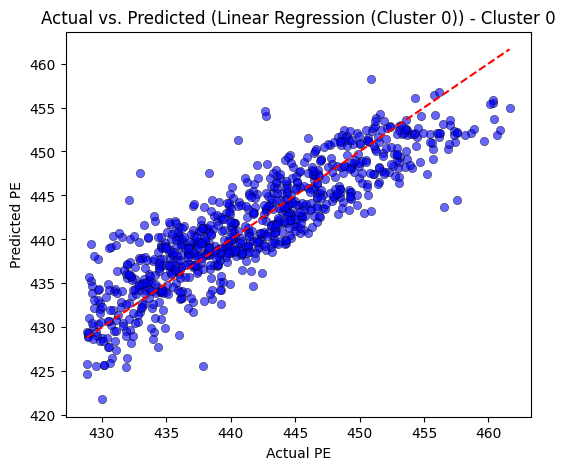

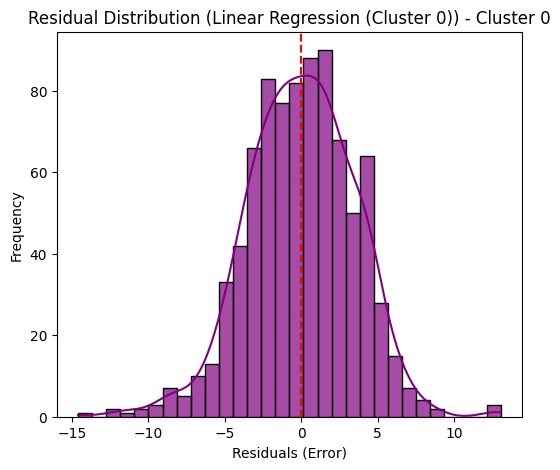

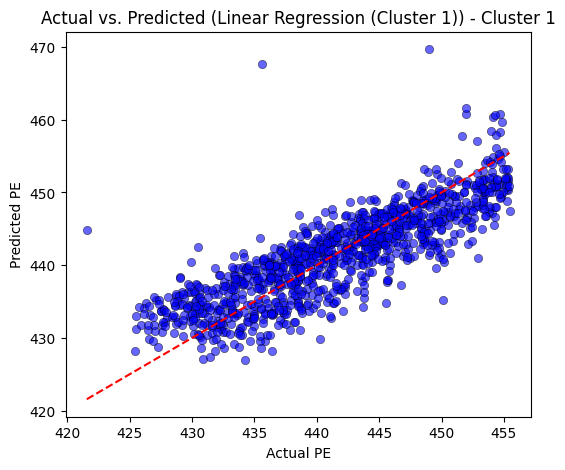

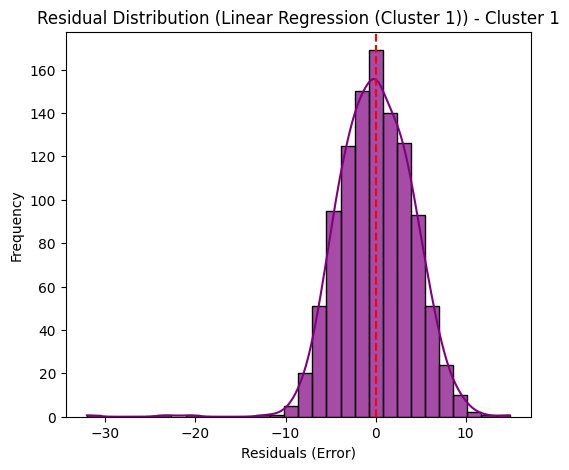

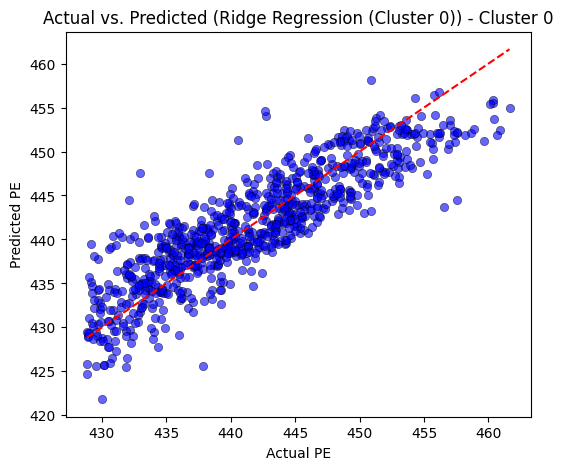

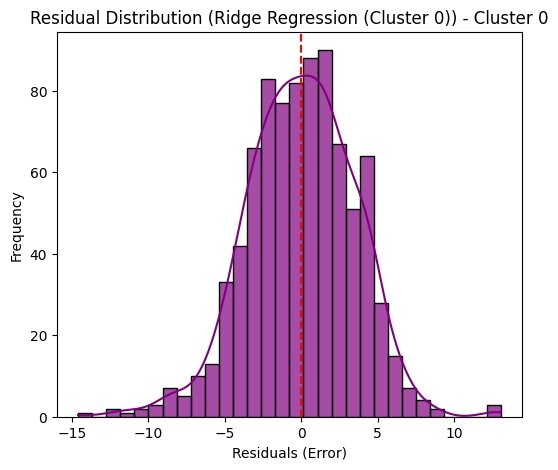

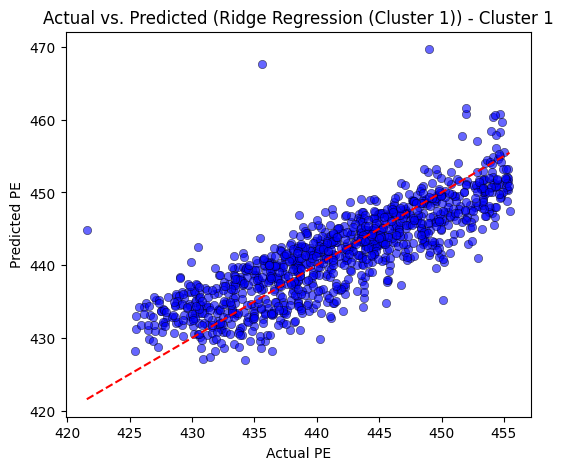

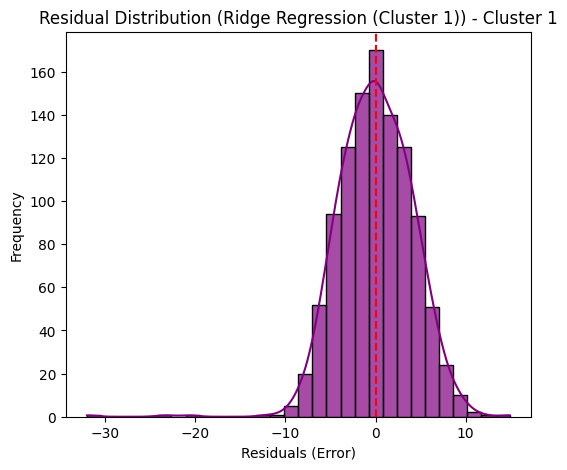

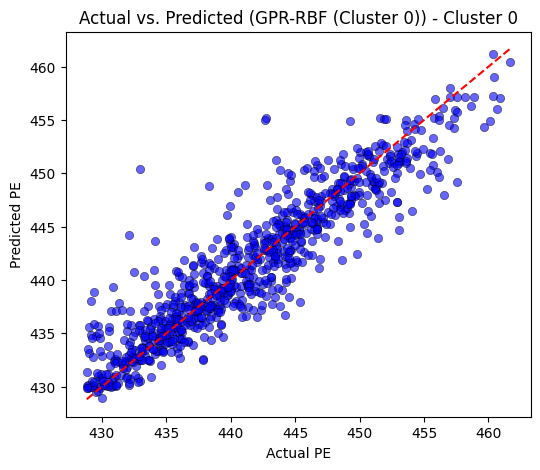

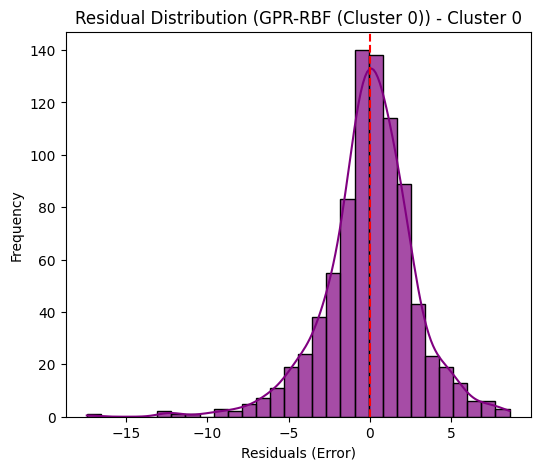

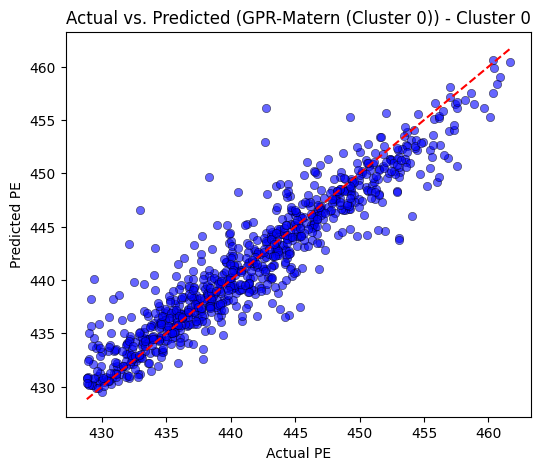

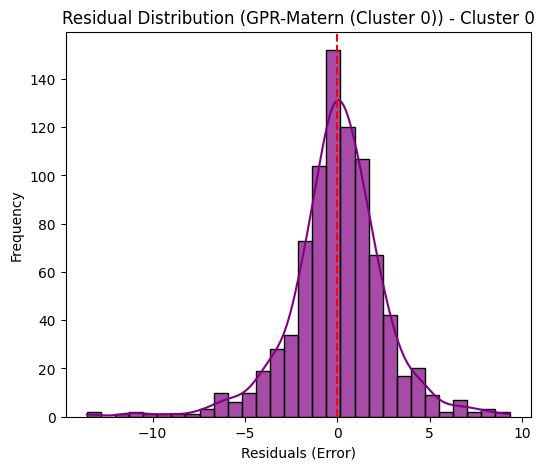

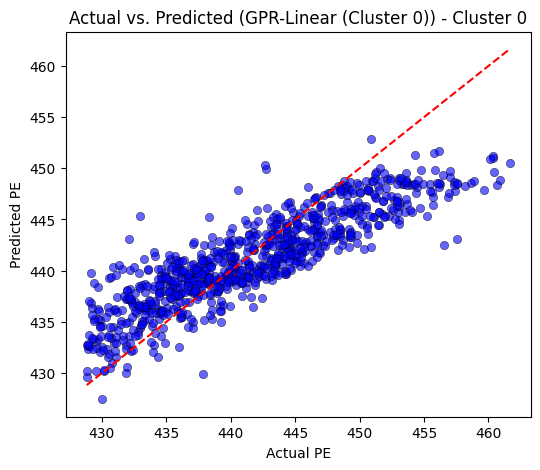

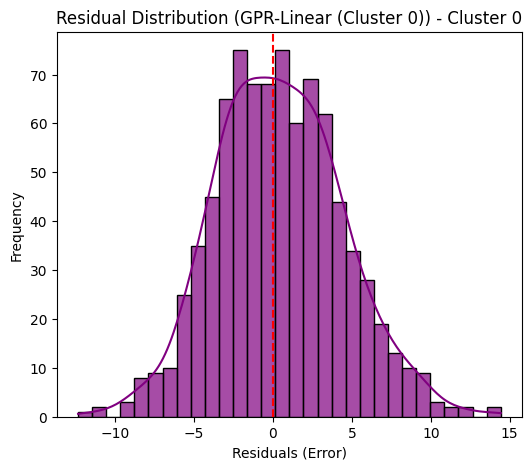

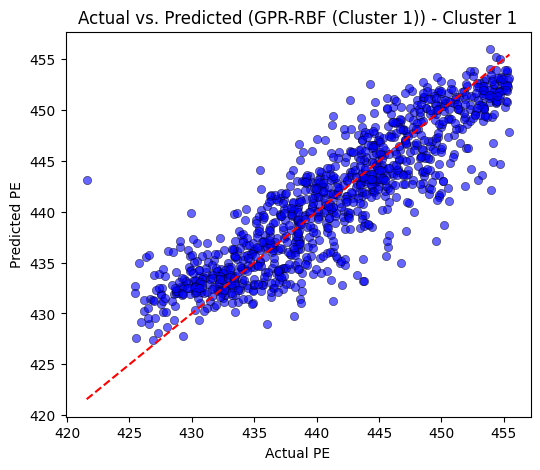

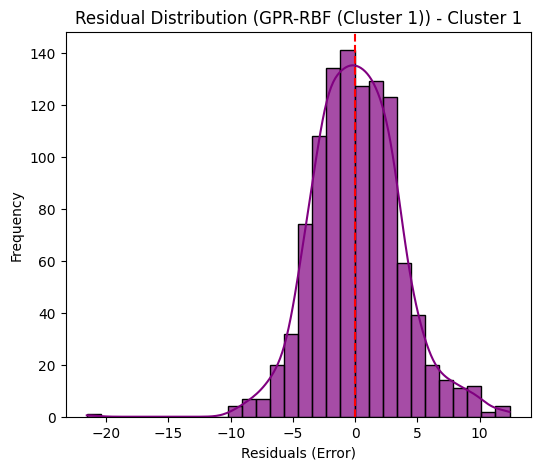

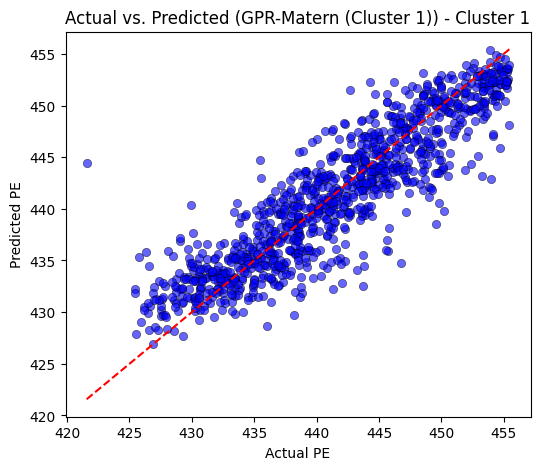

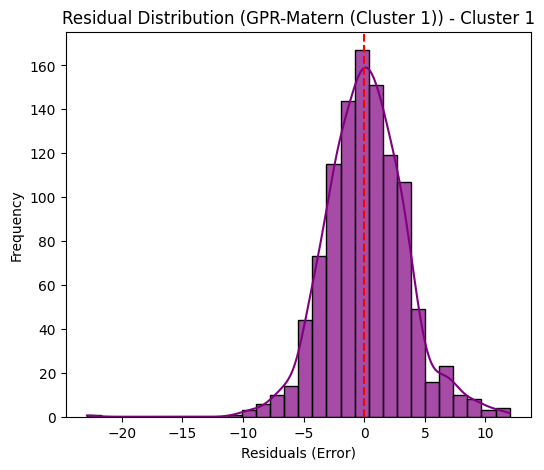

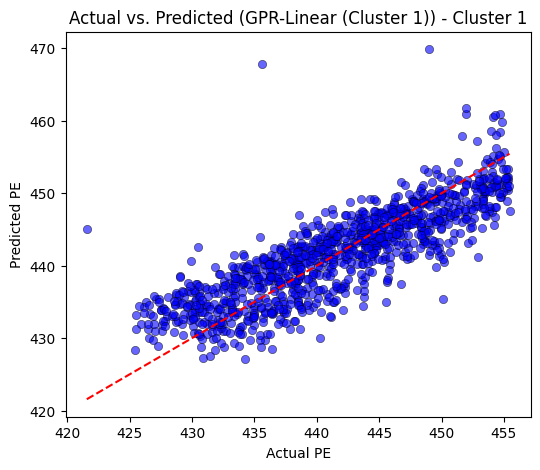

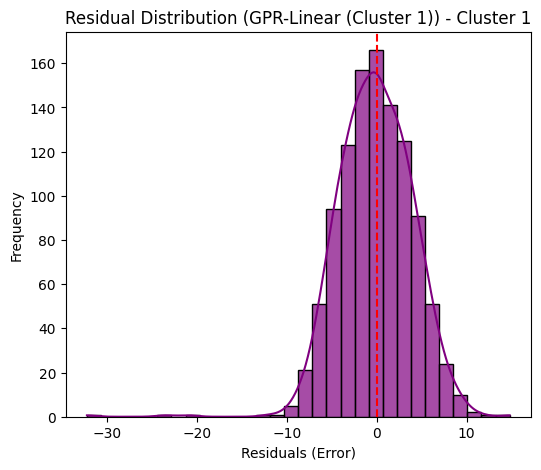

In [53]:
# Function to plot Residuals
def plot_residuals(y_actual, y_pred, model_name, cluster):
    residuals = y_actual - y_pred
    plt.figure(figsize=(6, 5))
    sns.histplot(residuals, bins=30, kde=True, color="purple", alpha=0.7)
    plt.axvline(x=0, color="red", linestyle="--")
    plt.xlabel("Residuals (Error)")
    plt.ylabel("Frequency")
    plt.title(f"Residual Distribution ({model_name}) - Cluster {cluster}")
    plt.show()

# Plot results for each model
for model_name, y_pred_actual in predictions.items():
    cluster = "0" if "Cluster 0" in model_name else "1"
    y_true_actual = y0_test_actual if cluster == "0" else y1_test_actual

    plot_actual_vs_pred(y_true_actual, y_pred_actual, model_name, cluster)
    plot_residuals(y_true_actual, y_pred_actual, model_name, cluster)

Feature Importance Analysis

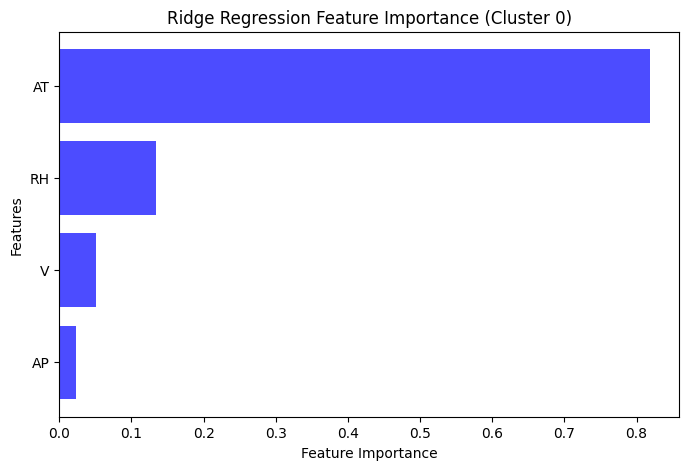

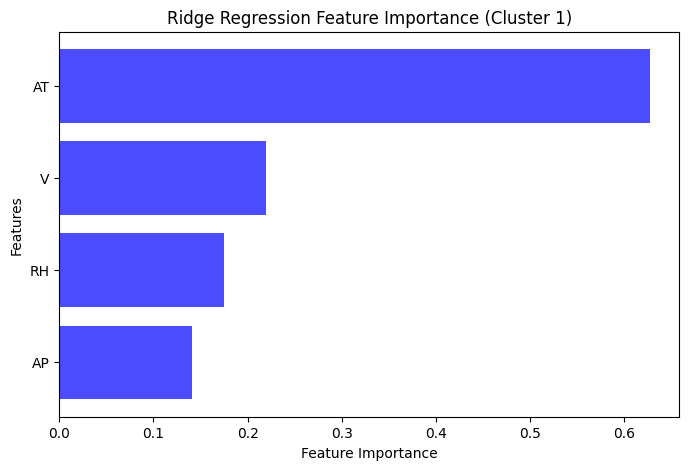

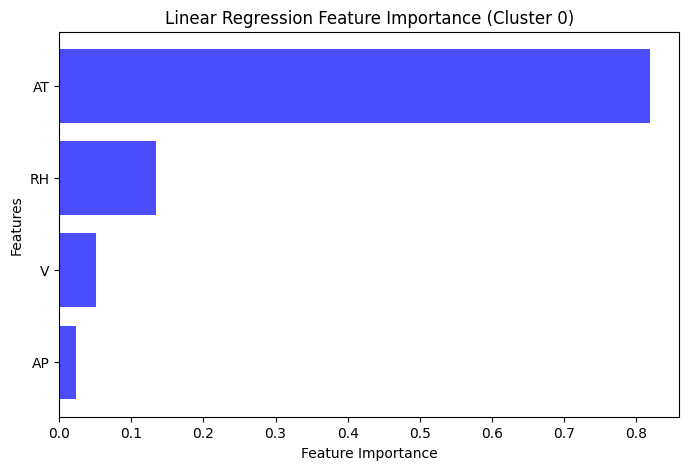

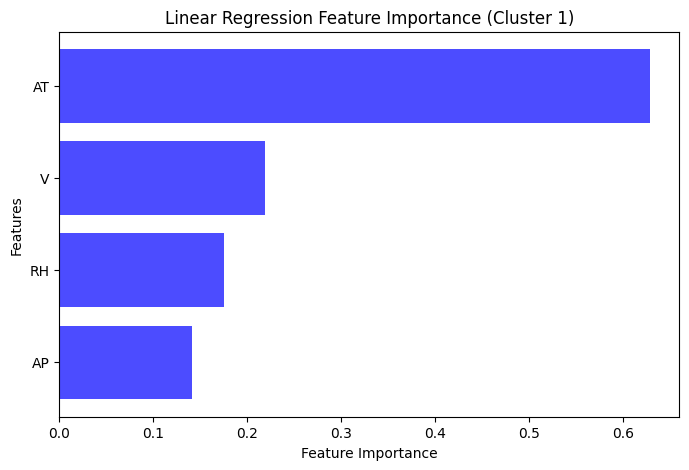

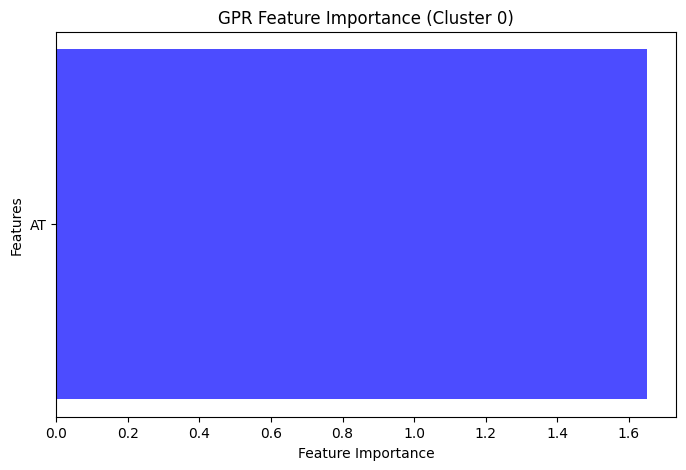

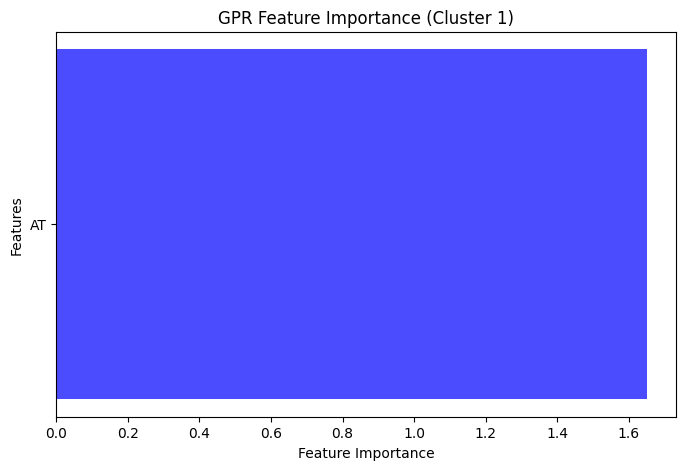

In [54]:
# Get feature names
feature_names = features

# Function to plot feature importance
def plot_feature_importance(importances, title):
    sorted_idx = np.argsort(importances)
    plt.figure(figsize=(8, 5))
    plt.barh(np.array(feature_names)[sorted_idx], np.array(importances)[sorted_idx], color='blue', alpha=0.7)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(title)
    plt.show()

# ---- Ridge & Linear Regression Feature Importance ----

# Get absolute coefficients
ridge_coeff_0 = np.abs(best_ridge_0.coef_)
ridge_coeff_1 = np.abs(best_ridge_1.coef_)

linear_coeff_0 = np.abs(lin_reg_0.coef_)
linear_coeff_1 = np.abs(lin_reg_1.coef_)

# Plot feature importance for Ridge & Linear Regression
plot_feature_importance(ridge_coeff_0, "Ridge Regression Feature Importance (Cluster 0)")
plot_feature_importance(ridge_coeff_1, "Ridge Regression Feature Importance (Cluster 1)")
plot_feature_importance(linear_coeff_0, "Linear Regression Feature Importance (Cluster 0)")
plot_feature_importance(linear_coeff_1, "Linear Regression Feature Importance (Cluster 1)")

# ---- GPR Feature Importance (Using Lengthscale) ----

# Function to extract and invert lengthscales (shorter = more important)
def extract_gpr_importance(gpr_model):
    lengthscales = gpr_model.kern.lengthscale.values
    return 1 / lengthscales  # Invert: shorter lengthscales = higher importance

gpr_importance_0 = extract_gpr_importance(gpr_models_0["RBF"])
gpr_importance_1 = extract_gpr_importance(gpr_models_1["RBF"])

# Plot GPR Feature Importance
plot_feature_importance(gpr_importance_0, "GPR Feature Importance (Cluster 0)")
plot_feature_importance(gpr_importance_1, "GPR Feature Importance (Cluster 1)")

Residuals vs Predited Values (Homoscendasticity Test)

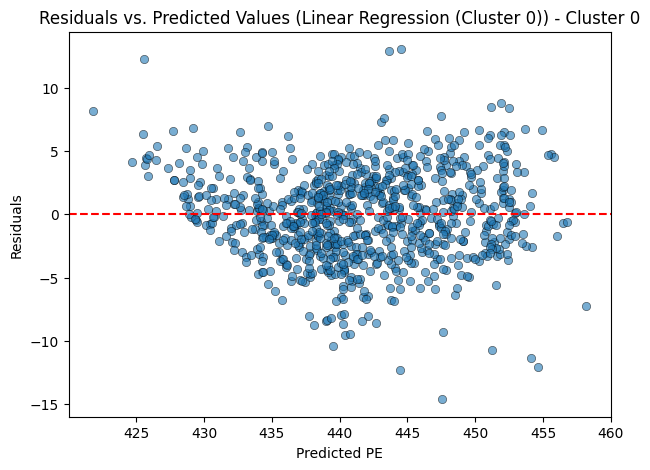

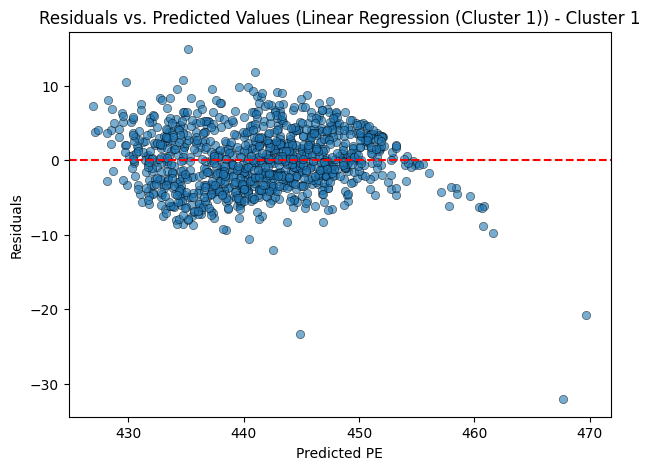

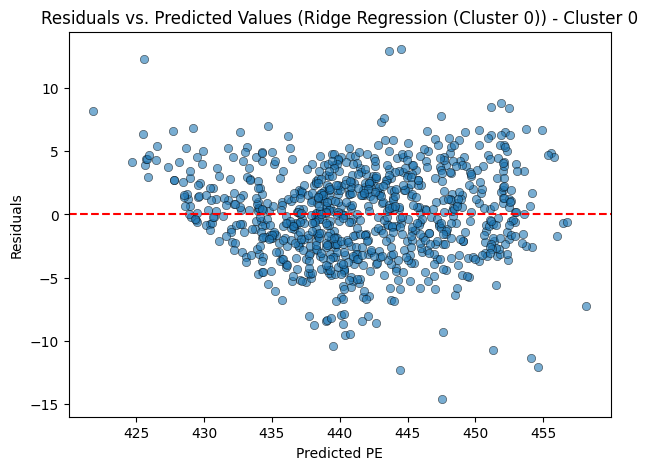

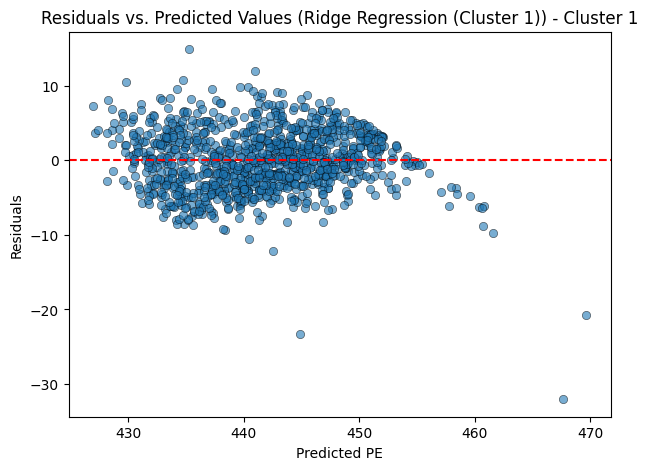

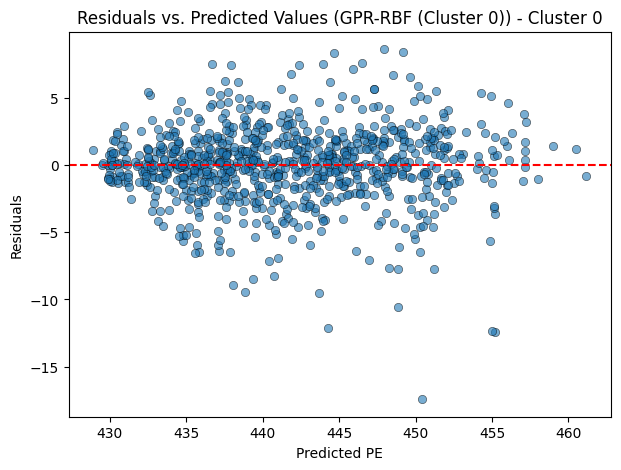

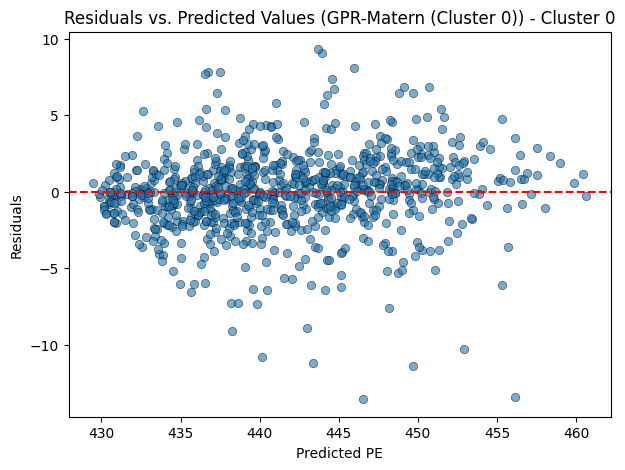

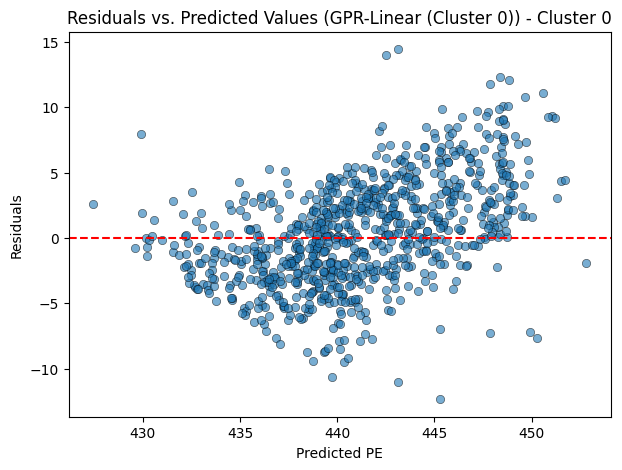

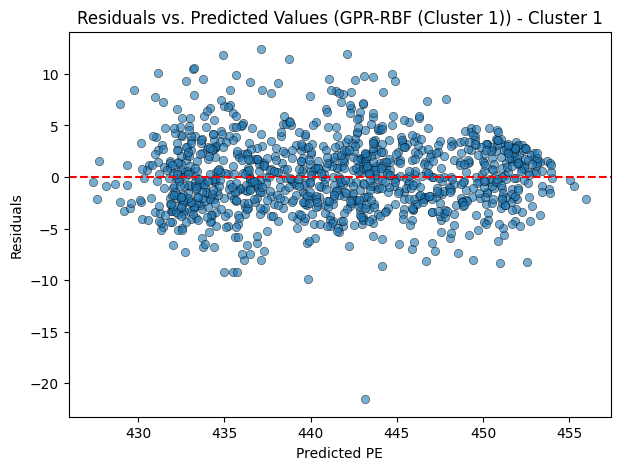

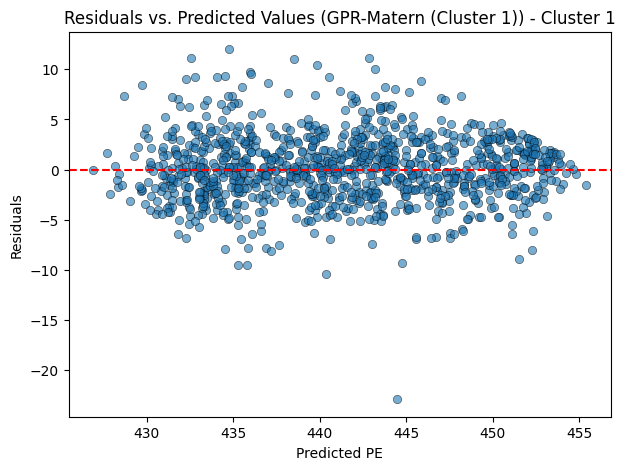

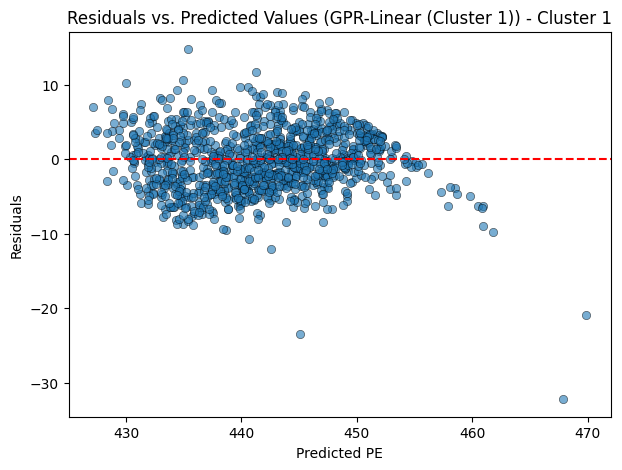

In [55]:
# Function to plot residuals vs. predicted values
def plot_residuals_vs_predicted(y_actual, y_pred, model_name, cluster):
    residuals = y_actual - y_pred

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor="k")
    plt.axhline(y=0, color="red", linestyle="--")  # Reference line at 0
    plt.xlabel("Predicted PE")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs. Predicted Values ({model_name}) - Cluster {cluster}")
    plt.show()

# Apply function to all models
for model_name, y_pred_actual in predictions.items():
    cluster = "0" if "Cluster 0" in model_name else "1"
    y_true_actual = y0_test_actual if cluster == "0" else y1_test_actual

    plot_residuals_vs_predicted(y_true_actual, y_pred_actual, model_name, cluster)

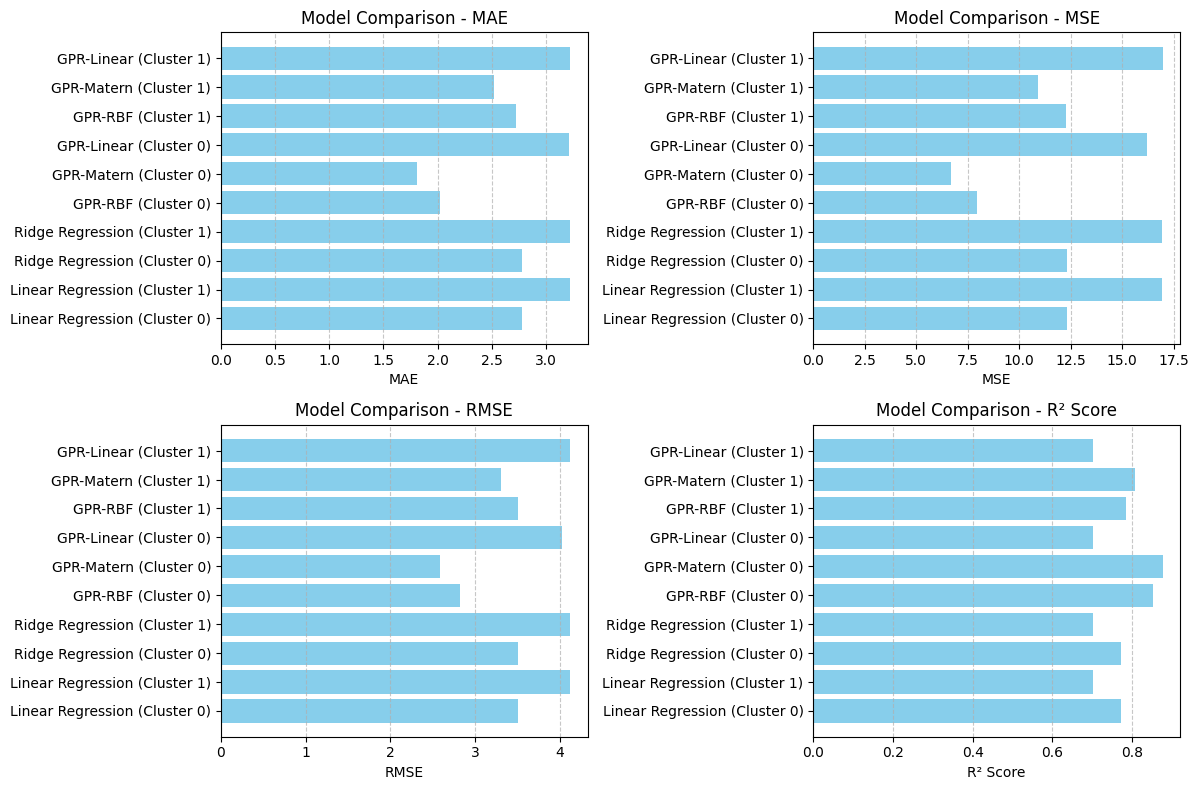

In [56]:
# Store model performance
performance_metrics = {"Model": [], "MAE": [], "MSE": [], "RMSE": [], "R² Score": []}

# Collect performance data
for model_name, y_pred_actual in predictions.items():
    y_true_actual = y0_test_actual if "Cluster 0" in model_name else y1_test_actual

    performance_metrics["Model"].append(model_name)
    performance_metrics["MAE"].append(mean_absolute_error(y_true_actual, y_pred_actual))
    performance_metrics["MSE"].append(mean_squared_error(y_true_actual, y_pred_actual))
    performance_metrics["RMSE"].append(np.sqrt(mean_squared_error(y_true_actual, y_pred_actual)))
    performance_metrics["R² Score"].append(r2_score(y_true_actual, y_pred_actual))

# Convert to numpy arrays
models = performance_metrics["Model"]
metrics = ["MAE", "MSE", "RMSE", "R² Score"]

# Plot bar charts
plt.figure(figsize=(12, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.barh(models, performance_metrics[metric], color='skyblue')
    plt.xlabel(metric)
    plt.title(f"Model Comparison - {metric}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

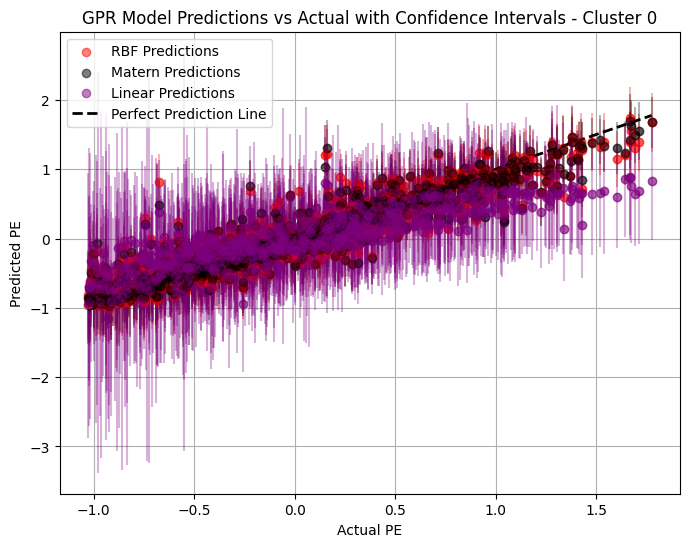

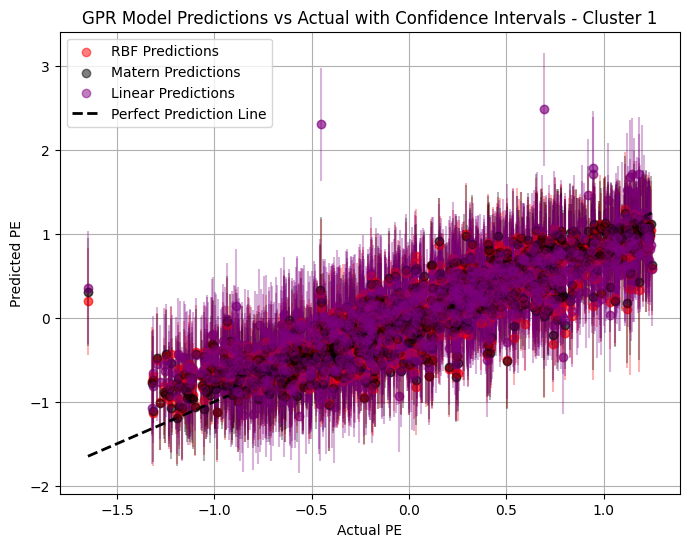

In [69]:
# Define colors for different kernels
kernel_colors = {
    "RBF": "red",
    "Matern32": "blue",
    "Matern52": "green",
    "Linear": "purple",
}

# Function to plot scatter plot with confidence intervals
def plot_gpr_scatter_ci(X_test, y_test, gpr_models, cluster):
    plt.figure(figsize=(8, 6))

    for kernel_name, gpr_model in gpr_models.items():
        # Predict mean and variance
        y_pred, y_var = gpr_model.predict(X_test)
        y_std = np.sqrt(y_var)  # Standard deviation

        # Get color for kernel
        color = kernel_colors.get(kernel_name, "black")

        # Scatter plot for predicted vs actual
        plt.scatter(y_test, y_pred, label=f"{kernel_name} Predictions", color=color, alpha=0.5)

        # 95% Confidence Interval lines
        plt.errorbar(y_test.flatten(), y_pred.flatten(), yerr=1.96 * y_std.flatten(), fmt='o', color=color, alpha=0.3)

    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2, label="Perfect Prediction Line")

    plt.xlabel("Actual PE")
    plt.ylabel("Predicted PE")
    plt.title(f"GPR Model Predictions vs Actual with Confidence Intervals - {cluster}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Scatter plot for each cluster using the correct variable names
plot_gpr_scatter_ci(X0_test, y0_test, gpr_models_0_h, cluster="Cluster 0")
plot_gpr_scatter_ci(X1_test, y1_test, gpr_models_1_h, cluster="Cluster 1")